<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/LSTM_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Resource: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# Explaination: https://www.youtube.com/watch?v=9TFnjJkfqmA&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=110

# There are many types of LSTM models that can be used for each specific type of time series forecasting problem.
# In this tutorial, you will discover how to develop a suite of LSTM models for a range of standard time series forecasting problems.

In [ ]:
# The models are demonstrated on small contrived time series problems intended to give the flavor of the type of time
#  series problem being addressed. The chosen configuration of the models is arbitrary and not optimized for each problem; 
#  that was not the goal.


<h1>Univariate LSTM Models</h1>

*   Data Preparation
*   Vanilla LSTM
*   Stacked LSTM
*   Bidirectional LSTM
*   CNN LSTM


In [ ]:
# These are problems comprised of a single series of observations and a model is required to learn from the series of 
# past observations to predict the next value in the sequence.

# Before a univariate series can be modeled, it must be prepared.
# The LSTM model will learn a function that maps a sequence of past observations as input Sequence to an output observation (next time step).
# As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.
# Consider a given univariate sequence:
# [10, 20, 30, 40, 50, 60, 70, 80, 90]
# We can divide the sequence into multiple input/output patterns called samples, where "three time steps" are used as 
# input and one time step is used as output for the one-step prediction that is being learned.
# X,				y
# 10, 20, 30		40
# 20, 30, 40		50
# 30, 40, 50		60
# 


In [ ]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
# Now that we know how to prepare a univariate series for modeling, let’s look at developing LSTM models that can 
# learn the mapping of inputs to outputs, starting with a Vanilla LSTM.

In [ ]:
# VANILLA LSTM

# A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

# We can define a Vanilla LSTM for univariate time series forecasting as follows: 
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# Key in the definition is the shape of the input; that is what the model expects as input for each sample in terms of the number 
# of time steps and the number of features.
# We are working with a univariate series, so the number of features is one, for one variable.
# The number of time steps as input is the number we chose when preparing our dataset as an argument to the split_sequence() function.
# We almost always have multiple samples, therefore, the model will expect the input component 
# of training data to have the shape:
# [samples, timesteps, features]

# Our split_sequence() function in the previous section outputs the X with the shape [samples, timesteps], 
# so we easily reshape it to have an additional dimension for the one feature.


In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

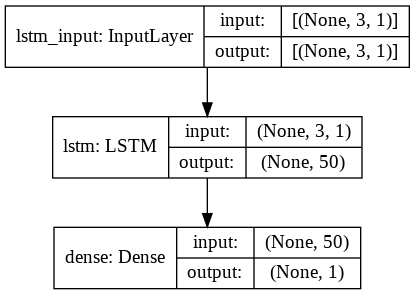

In [ ]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(model, show_shapes=True, to_file='vanilla_lstm.png')

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction, testing it
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.3089]]


In [ ]:
# We can see that the model predicts the next value in the sequence

In [ ]:
# STACKED LSTM

# Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

# An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as 
# an interpretation from the end of the sequence.
# We can address this by having the LSTM, to output a value for each time step in the input data by setting 
# the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

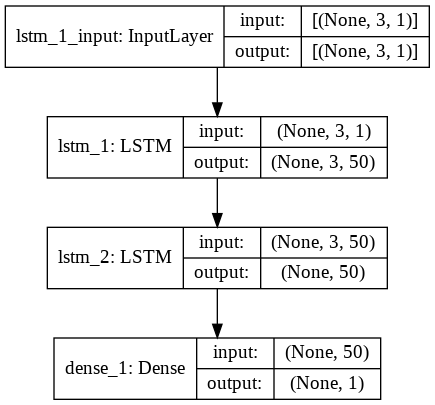

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='stacked_lstm.png')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.51523]]


In [ ]:
# Running the example predicts the next value in the sequence, which we expect would be 100

In [ ]:
# BIDIRECTIONAL LSTM

# On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and
# concatenate both interpretations.
# This is called a Bidirectional LSTM.

# We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping 
# the first hidden layer in a wrapper layer called Bidirectional.

# An example of defining a Bidirectional LSTM to read input from both forward as well from backward is as follows.

# define model
# model = Sequential()
# model.add(Bidirectional( LSTM(50, activation='relu'), input_shape=(n_steps, n_features) ))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [ ]:
from tensorflow.keras.layers import Bidirectional

# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

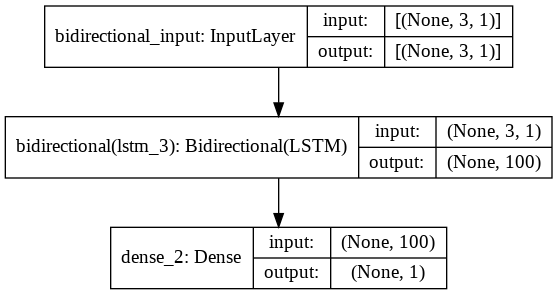

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='bidirectional_lstm.png')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.13192]]


In [ ]:
# CNN-LSTM 
# A convolutional neural network, or CNN for short, is a type of neural network developed for working with 
# two-dimensional image data.

# The CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data 
# such as univariate time series data.

# A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences 
# of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.

# The first step is to split the input sequences into subsequences that can be processed by the CNN model.
# For example, we can first split our univariate time series data into input/output samples with four steps as input and 
# one as output. Each sample can then be split into two sub-samples, each with two time steps. 
# The CNN can interpret each subsequence of two time steps and provide a time series of interpretations of the subsequences 
# to the LSTM model to process as input.

# We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence 
# as n_steps. The input data can then be reshaped to have the required structure:
# [samples, subsequences, timesteps, features]

In [ ]:
# choose a number of time steps
n_steps = 4

# split into samples
X, y = split_sequence(raw_seq, n_steps)
print(X.shape)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
# we had 4 timesteps and for each timestep we want to divide it into the subsequences of length 2, 
# therefore total number of subsequences in each timestep = 4 / 2 = 2
n_steps = 2 

# therefore shape = (samples, no_of_sequences_in_each_timestep, length_of_each_sequnece, n_features)
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
print(X.shape)

(5, 4)
(5, 2, 2, 1)


In [28]:
# We want to reuse the same CNN model when reading in each sub-sequence of data separately.
# This can be achieved by wrapping the entire CNN model in a TimeDistributed wrapper that will apply the entire model once per input, 
# in this case, once per input subsequence.

# The CNN model first has a convolutional layer for reading across the subsequence that requires a number of filters and a 
# kernel size to be specified. The number of filters is the number of reads or interpretations of the input sequence. 
# The kernel size is the number of time steps included of each ‘read’ operation of the input sequence.

# The convolution layer is followed by a max pooling layer that distills the filter maps down to 1/2 of their size that 
# includes the most important features. These structures are then flattened down to a single one-dimensional vector to be used
#  as a single input time step to the LSTM layer.

In [32]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten


In [33]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

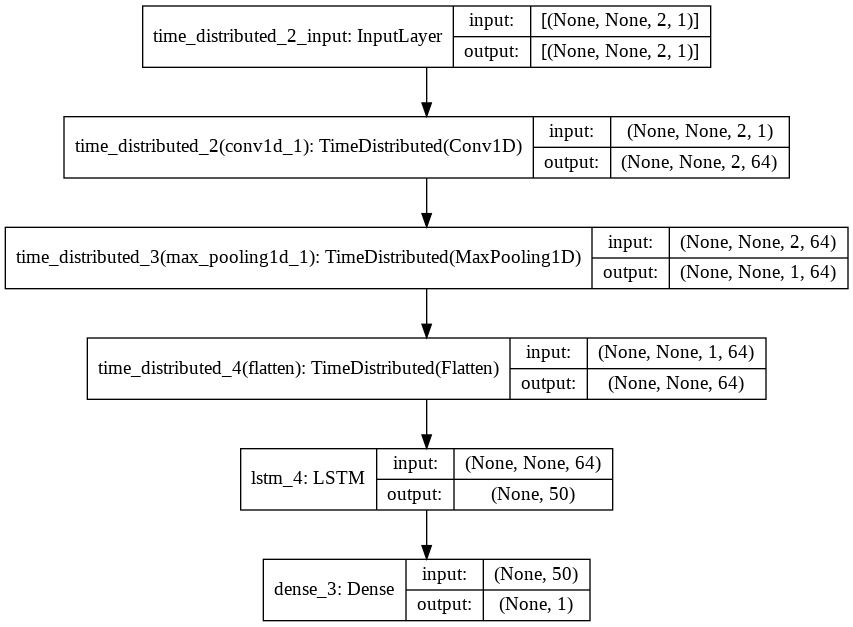

In [34]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='cnn_lstm.png')

In [35]:
model.compile(optimizer='adam', loss='mse')

In [36]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [37]:
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.86004]]


<h1>Multivariate LSTM models </h1>

In [38]:
# Multivariate time series data means data where there is more than one observation for each time step.
# There are two main models that we may require with multivariate time series data; they are:

# Multiple Input Series.
# Multiple Parallel Series.

In [39]:
# Multiple Input Series

# A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.
# The input time series are parallel because each series has an observation at the same time steps.
# We can demonstrate this with a simple example of two parallel input time series where the output series is 
# the simple addition of the input series.

# # define input sequence
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# We can reshape these three arrays of data as a single dataset where each row is a time step, 
# and each column is a separate time series. This is a standard way of storing parallel time series in a CSV file.

# convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape( (len(in_seq1), 1) )
# in_seq2 = in_seq2.reshape( (len(in_seq2), 1) )
# out_seq = out_seq.reshape( (len(out_seq), 1) )

# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))

In [40]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])

out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [41]:
from numpy import hstack

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

for row in dataset:
    print(row)

[10 15 25]
[20 25 45]
[30 35 65]
[40 45 85]
[ 50  55 105]
[ 60  65 125]
[ 70  75 145]
[ 80  85 165]
[ 90  95 185]


In [42]:
# As with the univariate time series, we must structure these data into samples with input and output elements.

# An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value. LSTMs can 
# support parallel input time series as separate variables or features. Therefore, we need to split the data into 
# samples maintaining the order of observations across the two input sequences.

# If we chose three input time steps, then the first sample would look as follows:
# Input:
# 10, 15
# 20, 25
# 30, 35

# Output: 65

# That is, the first three time steps of each parallel series are provided as input to the model and the model associates 
# this with the value in the output series at the third time step, in this case, 65.

# We can see that, in transforming the time series into input/output samples to train the model, that we 
# will have to discard some values from the output time series where we do not have values in the input time 
# series at prior time steps. In turn, the choice of the size of the number of input time steps will have an 
# important effect on how much of the training data is used.

In [43]:
# We can define a function named split_sequences() that will take a dataset as we have defined it with rows 
# for time steps and columns for parallel series and return input/output samples.

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
     
		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

In [44]:
# choose a number of time steps
n_steps = 3

# convert into input/output
X, y = split_sequences(dataset, n_steps)

print(X.shape, y.shape)
# summarize the data

for i in range(len(X)):
	print(X[i], y[i])

(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


In [45]:
# The first dimension is the number of samples, in this case 7. The second dimension is the number of time steps per sample, 
# in this case 3, the value specified to the function. Finally, the last dimension specifies the number of parallel time series 
# or the number of variables, in this case 2 for the two parallel series.

# This is the exact three-dimensional structure expected by an LSTM as input. The data is ready to use without further reshaping.

# We are now ready to fit an LSTM model on this data.

# Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional or CNN-LSTM.

# We will use a Vanilla LSTM where the number of time steps and parallel series (features) are specified for the input layer 
# via the input_shape argument.

In [46]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [47]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [48]:
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[206.79633]]


In [49]:
# Multiple Parallel Series

# An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.
# For example, given the data from the previous section:
# [[ 10  15  25]
#  [ 20  25  45]
#  [ 30  35  65]
#  [ 40  45  85]
#  [ 50  55 105]
#  [ 60  65 125]
#  [ 70  75 145]
#  [ 80  85 165]
#  [ 90  95 185]]

# We may want to predict the value for each of the three time series for the next time step.
# This might be referred to as multivariate forecasting.
# Again, the data must be split into input/output samples in order to train a model.

# The first sample of this dataset would be:
# Input: 
# 10, 15, 25
# 20, 25, 45
# 30, 35, 65

# Output: 40, 45, 85

In [50]:
# The split_sequences() function below will split multiple parallel time series with rows for time steps
#  and one series per column into the required input/output shape.

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
     
		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

In [52]:
# choose a number of time steps
n_steps = 3

# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i], end="\n\n")

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]

[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]

[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]

[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]

[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]

[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]



In [53]:
# The shape of X is three-dimensional, including the number of samples (6), the number of time steps chosen per sample (3), 
# and the number of parallel time series or features (3).

# The shape of y is two-dimensional as we might expect for the number of samples (6) and the number of time variables 
# per sample to be predicted (3).

# The data is ready to use in an LSTM model that expects three-dimensional input and two-dimensional output shapes 
# for the X and y components of each sample.

# We are now ready to fit an LSTM model on this data.
# Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional, CNN.
# We will use a Stacked LSTM where the number of time steps and parallel series (features) are specified 
# for the input layer via the input_shape argument. The number of parallel series is also used in the specification 
# of the number of values to predict by the model in the output layer; again, this is three.

In [61]:
n_features = X.shape[2]

# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model1.add(LSTM(100, activation='relu'))
# using the number of paralle series as number of output units
model1.add(Dense(n_features))

model1.compile(optimizer='adam', loss='mse')

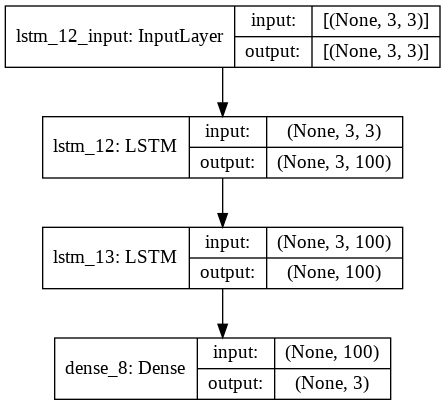

In [62]:
# plot model architecture
plot_model(model1, show_shapes=True, to_file='stacked_lstm1.png')

In [63]:
# fit model
model1.fit(X, y, epochs=200, verbose=0)

In [64]:
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[100.924286 105.925575 206.47696 ]]


<h1>Multi-Step LSTM Models</h1>

In [65]:
# A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to 
# as multi-step time series forecasting.

# There are two main types of LSTM models that can be used for multi-step forecasting; they are:

# Vector Output Model
# Encoder-Decoder Model

# Before we look at these models, let’s first look at the preparation of data for multi-step forecasting.

In [66]:
# Data Preparation

# As with one-step forecasting, a time series used for multi-step time series forecasting must be split into samples 
# with input and output components.
# Both the input and output components will be comprised of multiple time steps and may or may not have the same number of steps.

# For example, given the univariate time series:
# [10, 20, 30, 40, 50, 60, 70, 80, 90]

# We could use the last three time steps as input and forecast the next two time steps.

# The first sample would look as follows:
# Input: [10, 20, 30]
# Output: [40, 50]

In [67]:
# The split_sequence() function below implements this behavior and will split a given UNIVARIATE time series 
# into samples with a specified number of input and output time steps.

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
 
	for i in range(len(sequence)):
     
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out

		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

In [68]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [69]:
# Now that we know how to prepare data for multi-step forecasting, let’s look at some LSTM models that can learn this mapping.

In [70]:
# Vector Output Model

# Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast.
# This approach was seen in the previous section where one time step of each output time series was forecasted as a vector.

# As with the LSTMs for univariate data in a prior section, the prepared samples must first be reshaped. 
# The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, 
# we only have one feature so the reshape is straightforward.

In [71]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [72]:
# With the number of input and output steps specified in the n_steps_in and n_steps_out variables, 
# we can define a multi-step time-series forecasting model.

# Any of the presented LSTM model types could be used, such as Vanilla, Stacked, Bidirectional, CNN-LSTM, or ConvLSTM. 
# Below defines a Stacked LSTM for multi-step forecasting.

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse')

In [73]:
# fit model
model.fit(X, y, epochs=50, verbose=0)

In [74]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[119.15367 137.62825]]


In [75]:
# Encoder-Decoder Model

# A model specifically developed for forecasting variable length output sequences is called the Encoder-Decoder LSTM.

# The model was designed for prediction problems where there are both input and output sequences, so-called 
# sequence-to-sequence, or seq2seq problems, such as translating text from one language to another.

# This model can be used for multi-step time series forecasting.

# As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

# The encoder is a model responsible for reading and interpreting the input sequence. 
# The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence.
#  The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used such as Stacked, Bidirectional, 
# and CNN model
# model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))

# The decoder uses the output of the encoder as an input.
# First, the fixed-length output of the encoder is repeated, once for each required time step in the output sequence.
# model.add(RepeatVector(n_steps_out))

# This sequence is then provided to an LSTM decoder model. The model must output a value for each timestep 
# in the decoder, which can be interpreted by a single output model.
# model.add(LSTM(100, activation='relu', return_sequences=True))

# We can use the same output layer or layers to make each one-step prediction in the output sequence. 
# This can be achieved by wrapping the output part of the model in a TimeDistributed wrapper.
# model.add(TimeDistributed(Dense(1)))

In [77]:
from tensorflow.keras.layers import RepeatVector


In [78]:
# define model
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')

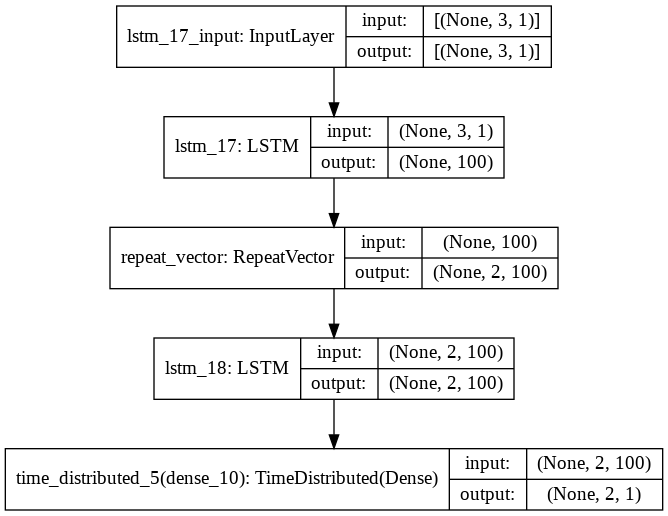

In [80]:
plot_model(model, show_shapes=True, to_file='encoder-decoder.png')

In [81]:
# fit model
model.fit(X, y, epochs=100, verbose=0)

In [82]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[101.607285]
  [113.12295 ]]]
